In [1]:
import numpy as np
import pandas as pd

from money_parser import price_dec
import lightgbm as lgbm

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer

pd.options.display.max_columns = None

In [2]:
def curr_to_float(v): return float(price_dec(v)) if v else v
def tf_to_10(v): return 1 if v == 't' else 0
def nulls_to_0(v): return float(0 if (pd.isnull(v) or v == '') else v)

converters_to_columns = [
    (curr_to_float, ['price', 'weekly_price', 'monthly_price']),
    (tf_to_10, ['instant_bookable', 'host_is_superhost']),
    (nulls_to_0, ['bedrooms', 'bathrooms'])
]

converters = {col: conv for conv, cols in converters_to_columns for col in cols}

df = pd.read_csv('data/listings.csv', index_col='id', converters=converters)

/home/abhivik/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.drop(['scrape_id', 'listing_url', 'last_scraped', 'space', 'description', 
         'picture_url', 'host_url', 'host_thumbnail_url', 'country', 'market', 
         'host_picture_url'], axis='columns')

,name,summary,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,xl_picture_url,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,country_code,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,NaN,4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,0,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,Manhattan,New York,NY,10027,"New York, NY",US,40.80902,-73.94190,t,Apartment,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",NaN,150.0,,,$200.00,$75.00,2,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,0,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3831,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,NaN,4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,0,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,Brooklyn,Brooklyn,NY,11238,"Brooklyn, NY",US,40.68514,-73.95976,t,Guest suite,Entire home/apt,3,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",500.0,89.0,575,2100,$500.00,NaN,1,$0.00,1,730,1,1,730,730,1.0,730.0,3 days ago,t,1,3,8,192,2019-09-13,279,67,2014-09-30,2019-08-29,90.0,9.0,9.0,10.0,9.0,10.0,9.0,f,NaN,NaN,0,f,moderate,f,f,1,1,0,0,4.62
5022,Entire Apt: Spacious Studio/Loft by central park,NaN,none,NaN,NaN,NaN,NaN,NaN,Please be considerate when staying in the apar...,NaN,NaN,NaN,7192,Laura,2009-01-29,"Miami, Florida, United States",I have been a NYer for almost 10 years. I came...,NaN,NaN,NaN,0,East Harlem,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"New York, NY, United States",East Harlem,East Harlem,Manhattan,New York,NY,10029,"New York, NY",US,40.79851,-73.94399,t,Apartment,Entire home/apt,1,1.0,0.0,1.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,

In [9]:
imp_df = df.copy()
imp_df = imp_df[['host_is_superhost', 'neighbourhood', 'accommodates', 'bathrooms', 
                 'bedrooms', 'room_type', 'property_type', 'number_of_reviews', 'price', 
                 'zipcode', 'latitude', 'longitude']]
# 'amenities', 'bed_type'

In [10]:
imp_df['neighbourhood'], neighbourhood_map = pd.factorize(df['neighbourhood'])
imp_df['property_type'], property_type_map = pd.factorize(df['property_type'])
# imp_df['bed_type'], bed_type_map = pd.factorize(df['bed_type'])
imp_df['room_type'], room_type_map = pd.factorize(df['room_type'])
imp_df['zipcode'], room_type_map = pd.factorize(df['zipcode'])

In [11]:
X = imp_df.drop('price', axis='columns').values
y = imp_df['price'].values

const_params = {
    'objective':                      'regression', 
    'metric':                         'rmse',
    'n_jobs':                         -1
}

tuning_parameters = {
    'learning_rate':                  [0.11, 0.115, 0.12], 
    'max_depth':                      [20], 
    'n_estimators':                   [275, 280, 285], 
    'random_state':                   [0]
}

def rmse(y_true, y_pred): return abs(np.sqrt(mean_squared_error(y_true, y_pred)))
scorer = make_scorer(rmse, greater_is_better=False)

grid = GridSearchCV(lgbm.LGBMRegressor(**const_params), 
                    tuning_parameters, 
                    cv=StratifiedKFold(5), 
                    scoring=scorer, 
                    n_jobs=-1)

grid.fit(X, y)

print(f'Best parameters {grid.best_params_}.')
print(f'Best RMSE is {-1*grid.best_score_}.')

/home/abhivik/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/abhivik/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters {'learning_rate': 0.115, 'max_depth': 20, 'n_estimators': 275, 'random_state': 0}.
Best RMSE is 212.8396288841761.


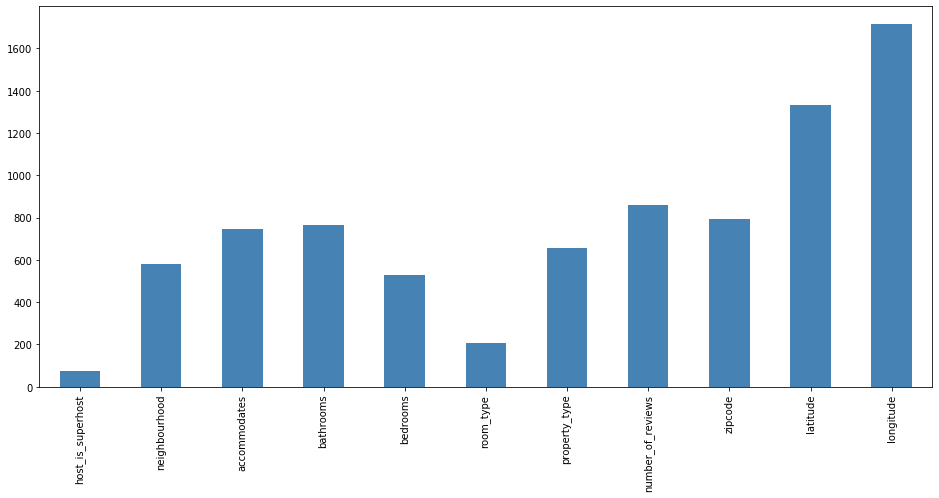

In [12]:
(pd.Series(grid.best_estimator_.feature_importances_, 
           index=imp_df.drop('price', axis='columns').columns.tolist())
 .plot.bar(color='steelblue', figsize=(16, 7)));